# Topic Modeling with BERT and Automatic Cluster Labeling

In [1]:
#https://github.com/rohan-paul/LLM-FineTuning-Large-Language-Models/blob/main/Other-Language_Models_BERT_related/Topic_Modeling_with_BERT_and_Automatic_cluster_labeling/Topic_Modeling.ipynb
#https://www.kaggle.com/datasets/andrewmvd/steam-reviews

In [2]:
import numpy as np 
import pandas as pd 
import random as rn
import re
import nltk
import os

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

from nltk.corpus import stopwords
from wordcloud import WordCloud

import umap # dimensionality reduction
import hdbscan # clustering
from functools import partial


import collections
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

import utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

In [3]:
#Load only 0.1% data
rn.seed(a=42)
p = 0.001  # to randomly select 0.1% of the rows

df_reviews = pd.read_csv('C:/Users/Abhishek_Jaiswal/Documents/TR_Project/AI_Projects/MMM/dataset.csv', skiprows=lambda i: i>0 and rn.random() > p)
# size of dataframe
print(df_reviews.shape)
# display the head of data
display(df_reviews.head())

(6227, 5)


,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1
1,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0
2,10,Counter-Strike,BEST GAME I EVER PLAYED TOTALLY AWESOME :D,1,0
3,10,Counter-Strike,I love this game :D,1,0
4,10,Counter-Strike,This game is Perfect !,1,0


<Axes: xlabel='review_score', ylabel='count'>

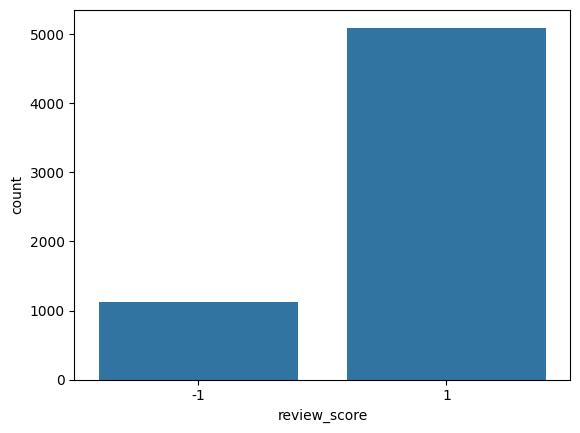

In [4]:
sns.countplot(x = 'review_score', data = df_reviews)

In [5]:
#Preprocess columns
df_reviews['review_text'] = df_reviews['review_text'].astype(str)
df_reviews['review_votes'] = df_reviews['review_votes'].astype(str)
#Strip spaces
df_reviews.review_text = df_reviews.review_text.apply(lambda s : s.strip())
#Drop rows whose review is NULL
df_reviews_2 = df_reviews[df_reviews['review_score'].notnull()]
#Replace -1 to 0 in Review Score column
df_reviews_2['review_score'] = np.where(df_reviews_2['review_score'] == -1, 0, df_reviews_2['review_score'])
df_reviews_2.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1
1,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0
2,10,Counter-Strike,BEST GAME I EVER PLAYED TOTALLY AWESOME :D,1,0
3,10,Counter-Strike,I love this game :D,1,0
4,10,Counter-Strike,This game is Perfect !,1,0


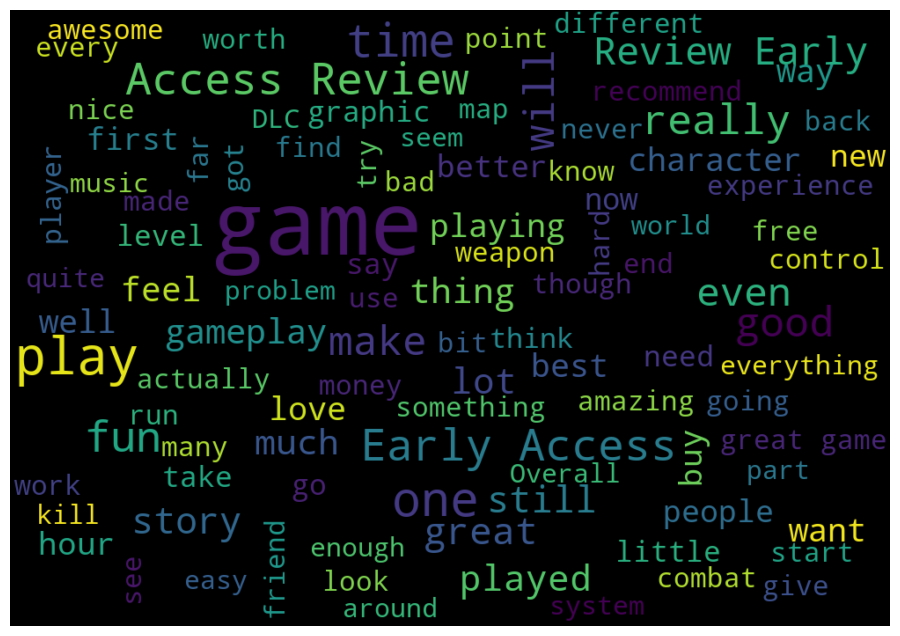

In [6]:
#Word cloud
txt = ' '.join(rev for rev in df_reviews_2.review_text )

plt.figure(figsize=(15, 8))

wordcloud = WordCloud(
    background_color='black',
    max_font_size=100,
    max_words=100, 
    width=1000, 
    height=700
).generate(txt)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [7]:
#Remove rows with 'Early Access Review' or nan in column review_text and drop duplicate wrt 'review_text', 'review_score'
df_reviews_2 = df_reviews_2[df_reviews_2.review_text != 'Early Access Review']
df_reviews_2 = df_reviews_2[~df_reviews_2.review_text.isin(['nan'])]
df_reviews_2.drop_duplicates(['review_text', 'review_score' ], inplace = True )
print(df_reviews_2.shape)

(5203, 5)


In [8]:
df_reviews_2.head()

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1
1,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0
2,10,Counter-Strike,BEST GAME I EVER PLAYED TOTALLY AWESOME :D,1,0
3,10,Counter-Strike,I love this game :D,1,0
4,10,Counter-Strike,This game is Perfect !,1,0


In [9]:
def replace_hearts_with_PAD(text):
    return re.sub(r"[♥]+", ' **** ' ,text)

# df_reviews_2['review_text_clean'] = df_reviews_2.review_text.apply(replace_hearts_with_PAD)
# df_reviews_2.head()

In [10]:
#Function to remove emoji
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)


#Clean some basic characters
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

#Remove numeric
def remove_num(texts):
    output = re.sub(r'\d+', '', texts )
    return output

#function to unify whitespaces
def unify_whitespaces(text):
    cleaned_string = re.sub(' +', ' ', text )
    return cleaned_string

#function to remove punctuation
def remove_punctuation(text):
    result = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',',') )
    return result

#remove stopwords
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop ]
    return ' '.join(text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abhishek_Jaiswal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#function to use stemming to normalize words
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def Stemming(text):
    stem = []
    stopword = stopwords.words('english')
    snowball_stemmer = SnowballStemmer('english')
    word_tokens = nltk.word_tokenize(text)
    stemmed_word = [ snowball_stemmer.stem(word) for word in word_tokens ]
    stem = ' '.join(stemmed_word)
    return stem

In [12]:
#Aplying all the cleaning util methods
def cleaning(df, review):
    df_processed = df.copy()
    df_processed[review] = df_processed['review_text']
    df_processed[review] = df_processed[review].apply(clean)
    df_processed[review] = df_processed[review].apply(deEmojify)
    df_processed[review] = df_processed[review].apply(replace_hearts_with_PAD)
    df_processed[review] = df_processed[review].apply(remove_num)
    df_processed[review] = df_processed[review].apply(remove_punctuation)
    df_processed[review] = df_processed[review].apply(remove_stopwords)
    df_processed[review] = df_processed[review].apply(unify_whitespaces)
    df_processed[review] = df_processed[review].apply(Stemming)
    return df_processed

df_processed = cleaning(df_reviews_2, 'review_text_clean' )

In [13]:
df_processed.head()

,app_id,app_name,review_text,review_score,review_votes,review_text_clean
0,10,Counter-Strike,"Score says it all. There's another version out called Counter-Strike: Source, but it's nothing compared to how the original Counter-Strike is. Plus, now adays it's really really cheap, like 10 dollars off of steam. As well, it has like the biggest competitive gaming community in the world, with hundreds of thousands of dollars worth of tournaments and players etc... good stuff.",1,1,score say there 's anoth version call counter-strik sourc noth compar origin counter-strik plus aday realli realli cheap like dollar steam well like biggest competit game communiti world hundr thousand dollar worth tournament player etc good stuff
1,10,Counter-Strike,"I really like the game, but I couldn’t find the stupid cake.",1,0,realli like game couldn ’ t find stupid cake
2,10,Counter-Strike,BEST GAME I EVER PLAYED TOTALLY AWESOME :D,1,0,best game ever play total awesom
3,10,Counter-Strike,I love this game :D,1,0,love game
4,10,Counter-Strike,This game is Perfect !,1,0,game perfect


In [14]:
print(df_processed.shape)
df_processed.review_score.value_counts()

(5203, 6)


review_score
1    4295
0     908
Name: count, dtype: int64

In [15]:
#Negative
neg_reviews = df_processed[df_processed.review_score == 0]
# Drop rows where the text length in 'column_name' is less than 10
neg_reviews = neg_reviews[neg_reviews['review_text_clean'].apply(lambda x: len(x) >= 50)]
print(neg_reviews.shape)
neg_reviews.head()

(676, 6)


,app_id,app_name,review_text,review_score,review_votes,review_text_clean
47,102700,A.V.A. Alliance of Valiant Arms™,"Tbh, I could see this game working if there were a few tweaks. Such as more TF2 items placed in the game that required you to play X amount of games. Ffs game, the only reason this is still going is people (me) wanting the black rose.",0,0,tbh could see game work tweak tf item place game requir play x amount game ffs game reason still go peopl ( me ) want black rose
48,102700,A.V.A. Alliance of Valiant Arms™,I downloaded the game for the Black Rose. Who here didn't? But I played multiple matches and it didn't give me the achievement!,0,0,download game black rose play multipl match give achiev
52,102700,A.V.A. Alliance of Valiant Arms™,"Just the usual Pay 2 Win wank. The infection mode thing was fun and some maps complimented the gunplay enough for it to be engaging for awhile, but since I came back to it for TF2 item, I found it has just went ♥♥♥♥ up, more hackers and more (overly expensive) pay 2 win garbage (exploitive character skins/equipment and OP weapons). If you can bare it for 'The Black Rose' go for it, otherwise...",0,1,usual pay win wank infect mode thing fun map compliment gunplay enough engag awhil sinc came back tf item found went * * * * hacker ( over expens ) pay win garbag ( exploit charact skins/equip op weapon ) bare the black rose ' go otherwis skip
59,104900,ORION: Prelude,"Today's Review: Orion: Prelude (Formally Orion: Dino Horde) Let me tell you a story about a bunch of 'developers' that thought that would be a great idea to launch an indie game, poorly optimized (i'll say not even tried), multiplayer game with dinosaurs and guns (FPS) and how they fail at the point they had to drop permanently the price from 9.99 to 0.99 due the fact that no one will ever bu...",0,1,today 's review orion prelud ( formal orion dino hord ) let tell stori bunch develop ' thought would great idea launch indi game poor optim ( i ll say even tri ) multiplay game dinosaur gun ( fps ) fail point drop perman price due fact one ever buy crap accept free game suck everi posibl way i ve play slaughter ground ride hell retribut rambo crappi game one worst one hell reach steam without ...
96,105600,Terraria,"Well I enjoyed it alot. About 4 years ago. It was easy then. Build. Jam to the awesome chiptune soundtrack. Mine. Fight the Wall of Flesh. Beat all the bosses. Grab the Excalibur. Done. They rammed in so many weapons that my inventory is constantly filled, and oh dear lord all of the particle effects. It litterally gets you to a point in the game where everything you own is overpowered, one ...",0,1,well enjoy alot year ago easi build jam awesom chiptun soundtrack mine fight wall flesh beat boss grab excalibur done ram mani weapon inventori constant fill oh dear lord particl effect litter get point game everyth overpow one shot poor littl rabbit basic monster noth challeng anymor litter decid use chrisma tree mulitpl freak yo-yo weapon gamenew order build mine jam still epic chiptun music...


In [16]:
#Sentence Embedding
from sentence_transformers import SentenceTransformer
import tensorflow as tf

# Define the embedding function
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences)
    return embeddings

# Load the SentenceTransformer model
model_st1 = SentenceTransformer('all-mpnet-base-v2', device='cpu')

# Create embeddings for the sentences in the DataFrame
embeddings_st1 = embed(model_st1, 'sentence transformer', neg_reviews['review_text_clean'].tolist())

# Add the embeddings as a new column in the DataFrame
neg_reviews['embeddings'] = list(embeddings_st1)
neg_reviews.head()

,app_id,app_name,review_text,review_score,review_votes,review_text_clean,embeddings
47,102700,A.V.A. Alliance of Valiant Arms™,"Tbh, I could see this game working if there were a few tweaks. Such as more TF2 items placed in the game that required you to play X amount of games. Ffs game, the only reason this is still going is people (me) wanting the black rose.",0,0,tbh could see game work tweak tf item place game requir play x amount game ffs game reason still go peopl ( me ) want black rose,"[0.029149596, -0.007736954, -0.029073546, 0.09041344, -0.038957026, -0.017893652, 0.019390034, 0.0074578132, -0.07263637, -0.0043708603, 0.037954245, 0.03131768, 0.025738344, 0.13273436, -0.012832241, 0.012684221, -0.047027405, 0.035814244, 0.025725491, 0.008473093, 0.016123714, -0.008284544, 0.024434907, 0.007933777, 0.041871767, -0.021129213, -0.056557477, 0.023841232, -0.0069720936, -0.0574..."
48,102700,A.V.A. Alliance of Valiant Arms™,I downloaded the game for the Black Rose. Who here didn't? But I played multiple matches and it didn't give me the achievement!,0,0,download game black rose play multipl match give achiev,"[0.004213659, -0.0326374, -0.022022841, 0.06430565, -0.048744064, -0.01077855, -0.0067229294, -0.01741912, -0.024929166, 0.018444406, 0.004540927, 0.01755881, 0.021045294, 0.15070812, 0.026779864, -0.015394858, -0.0059995037, 0.01112559, -0.007785791, -0.031631317, 0.033732023, -0.014128256, -0.032144688, 0.0011552671, 0.0021986365, -0.011276398, -0.020352867, 0.012827761, -0.019731415, -0.050..."
52,102700,A.V.A. Alliance of Valiant Arms™,"Just the usual Pay 2 Win wank. The infection mode thing was fun and some maps complimented the gunplay enough for it to be engaging for awhile, but since I came back to it for TF2 item, I found it has just went ♥♥♥♥ up, more hackers and more (overly expensive) pay 2 win garbage (exploitive character skins/equipment and OP weapons). If you can bare it for 'The Black Rose' go for it, otherwise...",0,1,usual pay win wank infect mode thing fun map compliment gunplay enough engag awhil sinc came back tf item found went * * * * hacker ( over expens ) pay win garbag ( exploit charact skins/equip op weapon ) bare the black rose ' go otherwis skip,"[-0.008703551, -0.059710145, 0.011037837, 0.054721612, -0.08055327, 0.015227751, -0.047358368, 0.00049430894, 0.008105654, 0.010312217, -0.018841323, 0.011340337, 0.07348788, 0.07420912, 0.044398192, 0.0068237856, -0.016507355, -0.040122088, -0.08436708, 0.007644265, 0.0006549445, -0.025380386, -0.019439008, 0.05114673, 0.046105836, -0.024798281, -0.031051295, 0.05597315, 0.03220725, -0.047845..."
59,104900,ORION: Prelude,"Today's Review: Orion: Prelude (Formally Orion: Dino Horde) Let me tell you a story about a bunch of 'developers' that thought that would be a great idea to launch an indie game, poorly optimized (i'll say not even tried), multiplayer game with dinosaurs and guns (FPS) and how they fail at the point they had to drop permanently the price from 9.99 to 0.99 due the fact that no one will ever bu...",0,1,today 's review orion prelud ( formal orion dino hord ) let tell stori bunch develop ' thought would great idea launch indi game poor optim ( i ll say even tri ) multiplay game dinosaur gun ( fps ) fail point drop perman price due fact one ever buy crap accept free game suck everi posibl way i ve play slaughter ground ride hell retribut rambo crappi game one worst one hell reach steam without ...,"[0.050096206, 0.007222681, -0.013886759, -0.017368456, -0.012184616, 0.00912294, -0.005036745, 0.010288191, -0.1075325, -0.0065878294, -0.07341001, 0.012733951, 0.028957771, 0.074500434, -0.011288031, -0.044721235, 0.033136416, -0.026570927, -0.03202172, 0.016338952, -0.006331935, -0.011807611, -0.021288479, -0.008027995, 0.00062656065, -0.047232173, -0.0014045261, 0.017677112, 0.02032917, -0...."
96,105600,Terraria,"Well I enjoyed it alot. About 4 years ago. It was easy then. Build. Jam to the awesome chiptune soundtrack. Mine. Fight the

In [17]:
import umap
# Dimensionality Reduction using UMAP
umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
embedding_umap = umap_model.fit_transform(embeddings_st1)

# Add the UMAP embeddings as a new column in the DataFrame
neg_reviews['embedding_umap'] = list(embedding_umap)
neg_reviews.head(1)

,app_id,app_name,review_text,review_score,review_votes,review_text_clean,embeddings,embedding_umap
47,102700,A.V.A. Alliance of Valiant Arms™,"Tbh, I could see this game working if there were a few tweaks. Such as more TF2 items placed in the game that required you to play X amount of games. Ffs game, the only reason this is still going is people (me) wanting the black rose.",0,0,tbh could see game work tweak tf item place game requir play x amount game ffs game reason still go peopl ( me ) want black rose,"[0.029149596, -0.007736954, -0.029073546, 0.09041344, -0.038957026, -0.017893652, 0.019390034, 0.0074578132, -0.07263637, -0.0043708603, 0.037954245, 0.03131768, 0.025738344, 0.13273436, -0.012832241, 0.012684221, -0.047027405, 0.035814244, 0.025725491, 0.008473093, 0.016123714, -0.008284544, 0.024434907, 0.007933777, 0.041871767, -0.021129213, -0.056557477, 0.023841232, -0.0069720936, -0.0574...","[14.206643, 5.68263]"


In [18]:
import hdbscan
from hyperopt import hp, fmin, tpe, Trials


# Define the hyperparameter space for HDBSCAN
space = {
    'min_cluster_size': hp.choice('min_cluster_size', range(2, 10)),
    'min_samples': hp.choice('min_samples', range(1, 10))
}

# Define the objective function for HDBSCAN
def objective(params):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=int(params['min_cluster_size']),
                                min_samples=int(params['min_samples']),
                                metric='euclidean')
    cluster_labels = clusterer.fit_predict(embedding_umap)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    return -n_clusters

# Run Bayesian optimization
trials = Trials()
best_params = fmin(fn=objective,
                   space=space,
                   algo=tpe.suggest,
                   max_evals=50,  # Number of evaluations to perform
                   trials=trials)

print("Best parameters found:", best_params)

100%|████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.71trial/s, best loss: -197.0]
Best parameters found: {'min_cluster_size': 0, 'min_samples': 0}


In [19]:
# Clustering using the best parameters from optimization
#best_clusterer = hdbscan.HDBSCAN(min_cluster_size=best_params['min_cluster_size'],
#                                 min_samples=best_params['min_samples'],
#                                 metric='euclidean')

best_clusterer = hdbscan.HDBSCAN(min_cluster_size=3,
                                 min_samples=50,
                                 metric='euclidean')
best_cluster_labels = best_clusterer.fit_predict(embedding_umap)

# Add the best cluster labels as a new column in the DataFrame
neg_reviews['best_cluster'] = best_cluster_labels
neg_reviews.head(2)

,app_id,app_name,review_text,review_score,review_votes,review_text_clean,embeddings,embedding_umap,best_cluster
47,102700,A.V.A. Alliance of Valiant Arms™,"Tbh, I could see this game working if there were a few tweaks. Such as more TF2 items placed in the game that required you to play X amount of games. Ffs game, the only reason this is still going is people (me) wanting the black rose.",0,0,tbh could see game work tweak tf item place game requir play x amount game ffs game reason still go peopl ( me ) want black rose,"[0.029149596, -0.007736954, -0.029073546, 0.09041344, -0.038957026, -0.017893652, 0.019390034, 0.0074578132, -0.07263637, -0.0043708603, 0.037954245, 0.03131768, 0.025738344, 0.13273436, -0.012832241, 0.012684221, -0.047027405, 0.035814244, 0.025725491, 0.008473093, 0.016123714, -0.008284544, 0.024434907, 0.007933777, 0.041871767, -0.021129213, -0.056557477, 0.023841232, -0.0069720936, -0.0574...","[14.206643, 5.68263]",-1
48,102700,A.V.A. Alliance of Valiant Arms™,I downloaded the game for the Black Rose. Who here didn't? But I played multiple matches and it didn't give me the achievement!,0,0,download game black rose play multipl match give achiev,"[0.004213659, -0.0326374, -0.022022841, 0.06430565, -0.048744064, -0.01077855, -0.0067229294, -0.01741912, -0.024929166, 0.018444406, 0.004540927, 0.01755881, 0.021045294, 0.15070812, 0.026779864, -0.015394858, -0.0059995037, 0.01112559, -0.007785791, -0.031631317, 0.033732023, -0.014128256, -0.032144688, 0.0011552671, 0.0021986365, -0.011276398, -0.020352867, 0.012827761, -0.019731415, -0.050...","[14.205285, 5.996639]",-1


C:\Users\Abhishek_Jaiswal\AppData\Local\Temp\ipykernel_36512\2232634028.py:4: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=embedding_umap[:, 0], y=embedding_umap[:, 1],


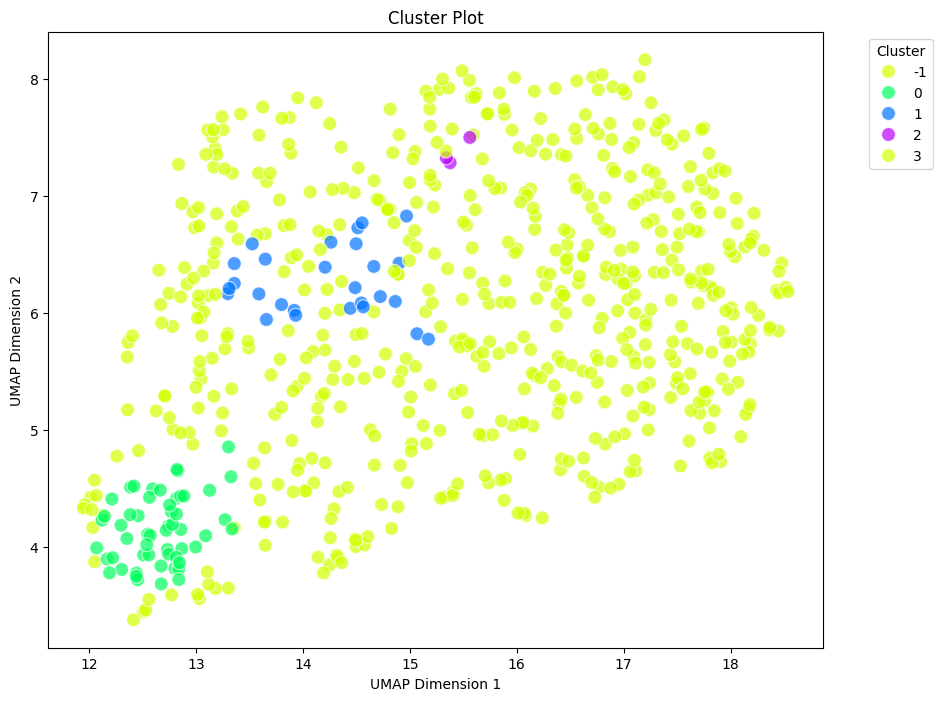

In [20]:
# Plotting
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hsv", len(set(best_cluster_labels)) - (1 if -1 in best_cluster_labels else 0))
sns.scatterplot(x=embedding_umap[:, 0], y=embedding_umap[:, 1], 
                hue=neg_reviews['best_cluster'], palette=palette, s=100, alpha=0.7, edgecolor='w')

plt.title('Cluster Plot')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim
import matplotlib.pyplot as plt

In [ ]:
# Create a dictionary and a corpus
dictionary = corpora.Dictionary(neg_reviews['review_text_clean'])
corpus = [dictionary.doc2bow(text) for text in neg_reviews['review_text_clean']]

# Define the LDA model
num_topics = 3  # Number of topics to extract
lda_model = models.LdaModel(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics,
                            random_state=42,
                            update_every=1,
                            chunksize=10,
                            passes=10,
                            alpha='auto')

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}\nWords: {topic}\n")

# Evaluate the model
coherence_model_lda = CoherenceModel(model=lda_model, texts=neg_reviews['review_text_clean'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')

# Visualize the topics (optional, using pyLDAvis)
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)